# PPO Training for Stock Trading

**Student Name:** Yuvraj Sehgal
**Student Number:** 6921795

---

## Overview

This notebook implements **Proximal Policy Optimization (PPO)** to train a reinforcement learning agent for **algorithmic stock trading** using historical market data.
The goal is to learn a trading policy that decides when to **buy**, **hold**, or **close** a position while accounting for transaction costs and realistic execution timing.

The implementation follows standard PPO best practices and emphasizes **logical correctness**, **reproducibility**, and **clear evaluation**, making it suitable for academic assessment.

---

## Key Components

### 1. Trading Environment
- Custom stock trading environment built on **Gymnasium**
- Uses **historical OHLCV price data**
- Trades are executed at **OPEN(t+1)** to avoid look-ahead bias
- Portfolio value is marked-to-market using **CLOSE(t)**
- Supports:
  - Holding penalties
  - Maximum holding duration
  - Optional reward shaping for trade exits
- Chronological **train/validation split** to prevent data leakage

---

### 2. Reinforcement Learning Algorithm
- **Proximal Policy Optimization (PPO)**
- On-policy actor–critic method
- Uses:
  - Generalized Advantage Estimation (GAE)
  - Clipped surrogate objective
  - Entropy regularization for exploration
  - Gradient clipping for stability
  - KL-divergence–based early stopping

---

### 3. Model Architecture
- **Actor–Critic networks** with shared feature extraction
- Two supported observation formats:
  - **MLP-based model** for vector observations
  - **1D CNN-based model** for time-series (State1D) observations
- Outputs:
  - Discrete action logits (Skip / Buy / Close)
  - State-value estimate for critic training

---

### 4. Training Loop
Each training rollout follows this sequence:
1. Collect on-policy rollouts from the environment
2. Compute advantages and returns using GAE
3. Perform multiple PPO update epochs on mini-batches
4. Log training diagnostics to **TensorBoard**
5. Periodically validate the policy and save checkpoints
6. Apply early stopping if validation performance stagnates

---

### 5. Evaluation and Backtesting
- Deterministic (**greedy**) and stochastic policy evaluation supported
- Backtests start with **$10,000 initial capital**
- All-in integer-share position sizing
- Transaction costs applied on every trade
- Optional forced liquidation at episode end for consistency
- Metrics reported:
  - Total return
  - Maximum drawdown
  - Number of trades
  - Win rate
  - Average trade return and holding duration
- Equity curves plotted for visual analysis

---

## Design Goals
- Avoid look-ahead bias
- Ensure logical trade execution timing
- Maintain reproducibility through fixed seeds
- Keep code modular, readable, and easy to grade
- Align implementation with PPO theory covered in class

---

## Notes for the Grader
- Training uses **stochastic actions** (required for PPO)
- Validation and backtesting use **greedy actions** for deterministic evaluation
- Action masking prevents invalid decisions (e.g., buying while already holding)
- All important events (training progress, validation results, checkpoints) are logged clearly

---

@References:

Class slides.

The in line comments, print statements, and code optimizations in the code have been done using ChatGPT.

Packt Publishing. (n.d.). Deep-Reinforcement-Learning-Hands-On (Chapter 08 source code) [GitHub repository]. GitHub. Retrieved December 28, 2025, from https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/tree/master/Chapter08


In [2]:
"""
Cell: Setup
- Imports dependencies
- Sets seeds for reproducibility
- Selects compute device (CPU/GPU)
- Creates output directories used for logs/checkpoints
"""

import os
import random
import time

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

# Custom trading environment + helpers
from stock_trading_env import StocksEnv, load_many_from_dir, split_many_by_ratio, Actions


def set_seed(seed: int, deterministic: bool = True) -> None:
    """
    Set random seeds for reproducible experiments.

    Args:
        seed: Global random seed used for Python, NumPy, and PyTorch.
        deterministic: If True, use deterministic CuDNN settings (slower but repeatable).
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# Reproducibility settings (kept constant across training/validation/backtests)
SEED = 0
set_seed(SEED, deterministic=True)

# Use GPU if available (PPO runs significantly faster on CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Standard output folders:
# - runs/: TensorBoard event files
# - saves/: saved model checkpoints
# - logs/: text logs (optional)
for d in ("runs", "saves", "logs"):
    os.makedirs(d, exist_ok=True)

print("✓ Imports successful")
print(f"Seed: {SEED}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ Imports successful
Seed: 0
PyTorch version: 2.9.0+cpu
CUDA available: False
Device: cpu


In [3]:
"""
Cell: PPO Actor–Critic Networks (Discrete Action Space)

Defines two actor–critic architectures used by PPO:
1) ActorCriticMLP   — for vector (flat) observations
2) ActorCriticConv1D — for time-series State1D observations (C × T)

Both networks output:
- policy logits for a Categorical action distribution
- a scalar value estimate V(s) for advantage estimation (GAE)
"""

import torch
import torch.nn as nn


class ActorCriticMLP(nn.Module):
    """
    Actor–Critic network for discrete-action PPO with vector observations.

    Input:
        x : Tensor of shape (B, obs_dim)

    Output:
        logits : Tensor of shape (B, n_actions)
                 Unnormalized action scores used with
                 torch.distributions.Categorical(logits=logits)
        value  : Tensor of shape (B,)
                 State-value estimate V(s)
    """

    def __init__(self, obs_dim: int, n_actions: int, hidden: int = 256):
        """
        Args:
            obs_dim: Dimension of the flattened observation vector.
            n_actions: Number of discrete actions.
            hidden: Width of hidden layers.
        """
        super().__init__()

        # Shared feature extractor (used by both actor and critic)
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # Separate heads for policy and value function
        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self) -> None:
        """
        Initialize weights using orthogonal initialization,
        which is standard practice for PPO.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0.0)

        # Smaller gain for policy head stabilizes early learning
        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        """
        Forward pass.

        Args:
            x: Observation tensor of shape (B, obs_dim)

        Returns:
            logits: Action logits (B, n_actions)
            value:  State value estimates (B,)
        """
        features = self.shared(x)
        logits = self.policy_head(features)
        value = self.value_head(features).squeeze(-1)
        return logits, value


class ActorCriticConv1D(nn.Module):
    """
    Actor–Critic network for discrete-action PPO with State1D observations.

    State1D format (from environment):
        x : Tensor of shape (B, C, T)

    Where:
        C = price channels + optional volume + position info
          = (3 + (1 if volumes else 0)) + 2
        T = number of time bars (e.g., 10)

    Output:
        logits : Tensor of shape (B, n_actions)
        value  : Tensor of shape (B,)
    """

    def __init__(
        self,
        n_actions: int,
        bars_count: int,
        volumes: bool = True,
        hidden: int = 256,
    ):
        """
        Args:
            n_actions: Number of discrete actions.
            bars_count: Number of historical bars in the State1D input.
            volumes: Whether volume is included in the state.
            hidden: Width of fully connected hidden layers.
        """
        super().__init__()

        # Number of input channels expected from the environment
        # Base channels: OHLC (3) + optional volume
        # Extra channels: position flag + unrealized return
        in_channels = (3 + (1 if volumes else 0)) + 2

        # Temporal convolution over bars
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # -> (B, 64 * bars_count)
        )

        conv_out_dim = 64 * bars_count

        # Shared MLP after convolution
        self.shared = nn.Sequential(
            nn.Linear(conv_out_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        # Policy and value heads
        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self) -> None:
        """
        Orthogonal initialization for both convolutional
        and linear layers (PPO best practice).
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.orthogonal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        """
        Forward pass.

        Args:
            x: State1D tensor of shape (B, C, T)

        Returns:
            logits: Action logits (B, n_actions)
            value:  State value estimates (B,)
        """
        conv_features = self.conv(x)
        features = self.shared(conv_features)
        logits = self.policy_head(features)
        value = self.value_head(features).squeeze(-1)
        return logits, value

In [4]:
"""
Cell: PPO Rollout Buffer

Implements a fixed-length rollout buffer used by PPO.
The buffer stores one on-policy trajectory segment and then computes:
- Generalized Advantage Estimation (GAE)
- Returns (value targets) for the critic

Supports both observation formats:
- Vector obs: (obs_dim,)
- State1D obs: (C, T)
"""

from dataclasses import dataclass
from typing import Iterator, Tuple, Union

import numpy as np
import torch


@dataclass
class PPOBatch:
    """
    One PPO minibatch (already moved to the target device).

    Fields match the quantities used in the PPO loss:
    - old_logprobs: log π_old(a|s) for importance sampling ratio
    - advantages: GAE advantages (optionally normalized)
    - returns: value targets for critic loss
    - old_values: V_old(s) (used if value clipping is enabled)
    """
    obs: torch.Tensor
    actions: torch.Tensor
    old_logprobs: torch.Tensor
    advantages: torch.Tensor
    returns: torch.Tensor
    old_values: torch.Tensor


class RolloutBuffer:
    """
    Fixed-length rollout storage for PPO.

    Stored per time-step t:
        obs[t], action[t], reward[t], done[t], value[t], logprob[t]

    After compute_gae():
        advantages[t] and returns[t] are filled.

    Notes:
    - In Gymnasium, an episode ends when terminated OR truncated. We store that as done=1.0.
    - All storage is numpy for speed; batches are converted to torch tensors during get_batches().
    """

    def __init__(
        self,
        obs_shape: Union[int, Tuple[int, ...]],
        size: int,
        device: Union[str, torch.device] = "cpu",
        obs_dtype: np.dtype = np.float32,
        pin_memory: bool = False,
    ):
        """
        Args:
            obs_shape: Observation shape (obs_dim) or (C, T).
            size: Number of steps collected per rollout (PPO rollout length).
            device: Torch device for training (cpu/cuda).
            obs_dtype: Numpy dtype used to store observations.
            pin_memory: If True and device is CUDA, pin CPU memory to speed up transfers.
        """
        if isinstance(obs_shape, int):
            obs_shape = (obs_shape,)

        self.obs_shape = tuple(obs_shape)
        self.size = int(size)
        self.device = torch.device(device) if not isinstance(device, torch.device) else device
        self.pin_memory = bool(pin_memory) and (self.device.type == "cuda")

        # Numpy storage (filled during rollout collection)
        self.obs = np.zeros((self.size, *self.obs_shape), dtype=obs_dtype)
        self.actions = np.zeros((self.size,), dtype=np.int64)
        self.rewards = np.zeros((self.size,), dtype=np.float32)
        self.dones = np.zeros((self.size,), dtype=np.float32)  # 1.0 if terminal else 0.0
        self.values = np.zeros((self.size,), dtype=np.float32)
        self.logprobs = np.zeros((self.size,), dtype=np.float32)

        # Computed after rollout
        self.advantages = np.zeros((self.size,), dtype=np.float32)
        self.returns = np.zeros((self.size,), dtype=np.float32)

        self.ptr = 0
        self.full = False

    def reset(self) -> None:
        """Clear the buffer pointer so a new rollout can be collected."""
        self.ptr = 0
        self.full = False

    def add(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        done: bool,
        value: float,
        logprob: float,
    ) -> None:
        """
        Add one transition (s_t, a_t, r_t, done_t, V(s_t), logπ(a_t|s_t)) to the buffer.
        """
        if self.ptr >= self.size:
            raise RuntimeError("RolloutBuffer is full; call reset() before collecting a new rollout.")

        obs_arr = np.asarray(obs, dtype=self.obs.dtype)

        # Enforce observation shape to prevent silent bugs (vector vs State1D mismatch)
        if obs_arr.shape != self.obs_shape:
            raise ValueError(f"Obs shape mismatch: got {obs_arr.shape}, expected {self.obs_shape}.")

        self.obs[self.ptr] = obs_arr
        self.actions[self.ptr] = int(action)
        self.rewards[self.ptr] = float(reward)
        self.dones[self.ptr] = 1.0 if bool(done) else 0.0
        self.values[self.ptr] = float(value)
        self.logprobs[self.ptr] = float(logprob)

        self.ptr += 1
        self.full = (self.ptr == self.size)

    @torch.no_grad()
    def compute_gae(
        self,
        last_value: float,
        gamma: float = 0.99,
        lam: float = 0.95,
        normalize_adv: bool = True,
        eps: float = 1e-8,
    ) -> None:
        """
        Compute GAE(λ) advantages and returns.

        Args:
            last_value: V(s_T) for the state after the last collected step.
                        Used for bootstrapping if the final transition is not terminal.
            gamma: Discount factor.
            lam: GAE λ parameter.
            normalize_adv: If True, normalize advantages for stability.
            eps: Small constant for numerical stability in normalization.
        """
        if not self.full:
            raise RuntimeError("Buffer must be full before calling compute_gae().")

        last_value = float(last_value)
        adv = 0.0

        for t in reversed(range(self.size)):
            mask = 1.0 - float(self.dones[t])  # 0 if terminal else 1
            next_value = last_value if (t == self.size - 1) else float(self.values[t + 1])

            # TD residual: δ_t = r_t + γ V(s_{t+1}) - V(s_t)
            delta = float(self.rewards[t]) + gamma * next_value * mask - float(self.values[t])

            # GAE recursion
            adv = delta + gamma * lam * mask * adv
            self.advantages[t] = adv

        # Return targets for critic: R_t = A_t + V(s_t)
        self.returns = self.advantages + self.values

        if normalize_adv:
            m = float(self.advantages.mean())
            s = float(self.advantages.std())
            self.advantages = (self.advantages - m) / (s + eps)

    def get_batches(self, batch_size: int, shuffle: bool = True) -> Iterator[PPOBatch]:
        """
        Yield minibatches as torch tensors on the configured device.

        Args:
            batch_size: Number of samples per minibatch.
            shuffle: If True, shuffle indices before batching.

        Yields:
            PPOBatch objects ready to be used in PPO updates.
        """
        if not self.full:
            raise RuntimeError("Buffer must be full before sampling minibatches.")
        if batch_size <= 0:
            raise ValueError("batch_size must be > 0")

        idxs = np.arange(self.size)
        if shuffle:
            np.random.shuffle(idxs)

        for start in range(0, self.size, batch_size):
            b_idx = idxs[start : start + batch_size]

            # Observations: move to device (optional pinning improves H2D transfer on CUDA)
            obs_cpu = torch.from_numpy(self.obs[b_idx]).float()
            if self.pin_memory:
                obs_cpu = obs_cpu.pin_memory()
            obs_t = obs_cpu.to(self.device, non_blocking=self.pin_memory)

            actions_t = torch.from_numpy(self.actions[b_idx]).long().to(self.device)
            old_logp_t = torch.from_numpy(self.logprobs[b_idx]).float().to(self.device)
            adv_t = torch.from_numpy(self.advantages[b_idx]).float().to(self.device)
            ret_t = torch.from_numpy(self.returns[b_idx]).float().to(self.device)
            old_v_t = torch.from_numpy(self.values[b_idx]).float().to(self.device)

            yield PPOBatch(
                obs=obs_t,
                actions=actions_t,
                old_logprobs=old_logp_t,
                advantages=adv_t,
                returns=ret_t,
                old_values=old_v_t,
            )

In [5]:
"""
Cell: Action Selection + Validation Metrics (PPO)

Defines:
- policy_act(): selects an action from the policy (greedy or sampled) and returns (action, logprob, value)
- explained_variance(): critic diagnostic
- validation_run_ppo(): evaluates the trained policy over multiple episodes and reports mean metrics

Important assumption:
- Trades are executed at OPEN(t+1), consistent with the environment implementation.
"""

from typing import Dict
import numpy as np
import torch
from torch.distributions import Categorical


@torch.no_grad()
def policy_act(model, obs, device: torch.device, greedy: bool = False):
    """
    Select an action from the current policy π(a|s).

    Args:
        model: Actor–critic network returning (logits, value).
        obs: Environment observation (vector (obs_dim,) or State1D (C, T)).
        device: Torch device (cpu/cuda).
        greedy: If True use argmax(logits); else sample from Categorical(logits).

    Returns:
        action: Selected discrete action (int).
        logprob: log π(a|s) under the current policy (float).
        value: Critic estimate V(s) (float).
    """
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, value = model(obs_t)

    dist = Categorical(logits=logits)
    action_t = torch.argmax(logits, dim=1) if greedy else dist.sample()
    logprob_t = dist.log_prob(action_t)

    return int(action_t.item()), float(logprob_t.item()), float(value.item())


def explained_variance(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """
    Critic diagnostic: explained variance of predictions.

    EV = 1 - Var(y_true - y_pred) / Var(y_true)
    - EV close to 1 indicates good value fit
    - EV near 0 indicates weak/no predictive power
    """
    var_y = float(np.var(y_true))
    if var_y < 1e-12:
        return 0.0
    return float(1.0 - np.var(y_true - y_pred) / (var_y + 1e-12))


@torch.no_grad()
def validation_run_ppo(
    env,
    model,
    episodes: int = 50,
    device="cpu",
    greedy: bool = False,
) -> Dict[str, float]:
    """
    Evaluate a PPO policy on the environment and return mean metrics.

    This validation computes:
    - episode reward and episode length
    - trade count, win rate, mean trade return, mean hold duration

    Execution assumption:
    - A decision at time t is executed at OPEN(t+1). We use env._state._prices.open[t+1]
      to approximate the execution price for reporting.
    """
    device = torch.device(device) if not isinstance(device, torch.device) else device

    # Ensure deterministic forward behavior during evaluation (e.g., no dropout)
    was_training = model.training
    model.eval()

    base_env = env.unwrapped if hasattr(env, "unwrapped") else env
    if not hasattr(base_env, "_state"):
        if was_training:
            model.train()
        raise AttributeError("validation_run_ppo expects env.unwrapped to expose attribute '_state'.")

    # Aggregate metrics across episodes (mean returned at the end)
    stats = {
        "episode_reward": [],
        "episode_steps": [],
        "num_trades": [],
        "win_rate": [],
        "avg_trade_return": [],
        "avg_hold_steps": [],
        "sum_trade_return": [],
    }

    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        # Manual trade tracking (independent of env rewards)
        in_pos = False
        entry_price = None
        hold_steps = 0
        trade_returns = []
        trade_hold_steps = []

        while not done:
            action, _lp, _v = policy_act(model, obs, device=device, greedy=greedy)

            # Convert action int -> Actions enum (fallback to Skip if unexpected)
            try:
                act_enum = Actions(action)
            except Exception:
                act_enum = Actions.Skip

            st = base_env._state
            next_idx = st._offset + 1  # execution index for OPEN(t+1)

            exec_open = None
            if 0 <= next_idx < st._prices.open.shape[0]:
                exec_open = float(st._prices.open[next_idx])

            # Track whether the env itself thinks we are in position
            # (used to detect forced exits such as liquidation/stop-loss rules)
            prev_have_pos_env = bool(st.have_position)

            # --- Trade accounting (using OPEN(t+1) as the execution price) ---
            if exec_open is not None:
                if act_enum == Actions.Buy and not in_pos:
                    in_pos = True
                    entry_price = exec_open
                    hold_steps = 0

                elif act_enum == Actions.Close and in_pos:
                    tr = 100.0 * (exec_open - entry_price) / entry_price if (entry_price and entry_price > 0) else 0.0
                    trade_returns.append(tr)
                    trade_hold_steps.append(hold_steps)
                    in_pos = False
                    entry_price = None
                    hold_steps = 0

            # Advance the environment
            obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            total_reward += float(reward)
            steps += 1

            # --- Detect forced exit by the environment ---
            now_have_pos_env = bool(base_env._state.have_position)
            if in_pos and prev_have_pos_env and (not now_have_pos_env) and act_enum != Actions.Close:
                # Prefer OPEN(t+1) if available; otherwise use current CLOSE for reporting
                exit_price = exec_open if exec_open is not None else float(base_env._state._cur_close())
                tr = 100.0 * (exit_price - entry_price) / entry_price if (entry_price and entry_price > 0) else 0.0
                trade_returns.append(tr)
                trade_hold_steps.append(hold_steps)
                in_pos = False
                entry_price = None
                hold_steps = 0

            # Holding time increments once per environment step while in position
            if in_pos:
                hold_steps += 1

        # If episode ends while holding, close the position at the final CLOSE for reporting
        if in_pos and entry_price is not None and entry_price > 0:
            last_close = float(base_env._state._cur_close())
            tr = 100.0 * (last_close - entry_price) / entry_price
            trade_returns.append(tr)
            trade_hold_steps.append(hold_steps)

        # --- Episode-level metrics ---
        stats["episode_reward"].append(total_reward)
        stats["episode_steps"].append(steps)

        n_trades = len(trade_returns)
        stats["num_trades"].append(float(n_trades))

        if n_trades > 0:
            wins = sum(1 for x in trade_returns if x > 0.0)
            stats["win_rate"].append(float(wins / n_trades))
            stats["avg_trade_return"].append(float(np.mean(trade_returns)))
            stats["avg_hold_steps"].append(float(np.mean(trade_hold_steps)))
            stats["sum_trade_return"].append(float(np.sum(trade_returns)))
        else:
            stats["win_rate"].append(0.0)
            stats["avg_trade_return"].append(0.0)
            stats["avg_hold_steps"].append(0.0)
            stats["sum_trade_return"].append(0.0)

    # Restore model mode so training code is unaffected
    if was_training:
        model.train()

    return {k: float(np.mean(v)) for k, v in stats.items()}

In [6]:
"""
Cell: Experiment Configuration

Defines all hyperparameters used for:
- data loading and train/validation split
- PPO training (gamma, GAE, clipping, optimizer, batch sizes)
- environment settings (state representation, reward mode, episode length)
- reward shaping to discourage over-holding and encourage sensible exits
- evaluation/checkpoint schedule and early stopping
"""

config = {
    # -----------------------------
    # Data + reproducibility
    # -----------------------------
    "data_dir": "yf_data",
    "run_name": f"ppo_{time.strftime('%Y%m%d_%H%M%S')}",
    "seed": 0,

    # -----------------------------
    # Compute device
    # -----------------------------
    "use_cuda": True,

    # -----------------------------
    # PPO hyperparameters
    # -----------------------------
    "gamma": 0.99,          # discount factor
    "gae_lambda": 0.95,     # GAE(λ) bias/variance trade-off
    "clip_eps": 0.2,        # PPO clipping range
    "lr": 3e-4,             # Adam learning rate
    "rollout_steps": 1024,  # steps collected per PPO rollout
    "minibatch": 256,       # minibatch size per PPO epoch
    "epochs": 5,            # gradient epochs per rollout
    "value_coef": 0.5,      # critic loss weight
    "entropy_coef": 0.025,  # entropy bonus weight (encourages exploration)
    "max_grad_norm": 0.5,   # gradient clipping
    "target_kl": 0.03,      # KL early-stopping threshold per update

    # -----------------------------
    # Environment configuration
    # -----------------------------
    "bars": 10,                 # number of historical bars in state
    "volumes": True,            # include volume feature
    "extra_features": True,     # include engineered features (if env supports)
    "reward_mode": "close_pnl", # primary reward definition
    "state_1d": False,          # False -> vector obs, True -> (C, T) State1D
    "time_limit": 1000,         # max steps per episode

    # -----------------------------
    # Reward shaping (reduce overtrading / encourage exits)
    # -----------------------------
    "hold_penalty_per_step": 2e-4,   # small cost per step while holding a position
    "max_hold_steps": 20,            # force exit after N steps (limits extreme holds)

    # Penalize staying in losing trades; bonus for realizing profits
    "unrealized_loss_penalty_per_step": 0.10,
    "close_profit_bonus": 0.20,

    # Optional: penalize high volatility while holding (disabled here)
    "unrealized_vol_penalty_per_step": 0.00,
    "vol_lookback": 20,

    # -----------------------------
    # Train/validation split
    # -----------------------------
    "split": True,
    "train_ratio": 0.8,
    "min_train": 300,
    "min_val": 300,

    # -----------------------------
    # Training budget
    # -----------------------------
    "max_rollouts": 500,
    "total_steps": 10_000_000,

    # -----------------------------
    # Validation + checkpointing
    # -----------------------------
    "val_every_rollouts": 10,
    "save_every_rollouts": 5,

    # Early stopping based on validation performance
    "early_stop": True,
    "patience": 20,
    "min_rollouts": 50,
    "min_delta": 0.01,
}

# Device selection for training/evaluation (GPU if available and enabled)
device = torch.device("cuda" if (config["use_cuda"] and torch.cuda.is_available()) else "cpu")

# Seed all RNGs so runs are repeatable
set_seed(config["seed"])

In [7]:
"""
Cell: Data Loading and Train/Validation Split

Loads historical price data, optionally splits it chronologically
into training and validation sets, and performs basic sanity checks
to ensure sufficient data length.
"""

# -----------------------------
# Load all available instruments
# -----------------------------
prices_all = load_many_from_dir(config["data_dir"])
print(f"Loaded {len(prices_all)} instrument(s) from '{config['data_dir']}'")

# -----------------------------
# Optional: restrict to a single instrument (e.g., AAPL)
# -----------------------------
# TARGET = "AAPL"
# if TARGET in prices_all:
#     prices_all = {TARGET: prices_all[TARGET]}
#     print(f"Using single instrument: {TARGET}")

# -----------------------------
# Train / validation split
# -----------------------------
if config["split"]:
    prices_train, prices_val = split_many_by_ratio(
        prices_all,
        train_ratio=config["train_ratio"],
        min_train=config["min_train"],
        min_val=config["min_val"],
    )
    print(
        f"Data split enabled: "
        f"{len(prices_train)} train instrument(s), "
        f"{len(prices_val)} validation instrument(s)"
    )
else:
    prices_train = prices_all
    prices_val = prices_all
    print("Data split disabled: using same data for training and validation")

# -----------------------------
# Sanity checks (length + leakage prevention)
# -----------------------------
for inst in prices_train.keys():
    train_len = len(prices_train[inst].close)
    val_len = len(prices_val[inst].close)

    if config["split"]:
        assert train_len >= config["min_train"], f"{inst}: training data too short ({train_len})"
        assert val_len >= config["min_val"], f"{inst}: validation data too short ({val_len})"

    print(f"{inst}: train_len={train_len}, val_len={val_len}")


Loaded 1 instrument(s) from 'yf_data'
Data split enabled: 1 train instrument(s), 1 validation instrument(s)
AAPL_1d_2020-01-01_to_2025-12-23: train_len=1201, val_len=301


In [8]:
"""
Cell: Environment Construction (Train + Validation)

Creates two Stock trading environments with identical settings:
- Training environment uses training price series
- Validation environment uses validation price series

Both environments:
- apply TimeLimit to cap episode length
- include reward shaping terms (holding penalty, max hold, and exit incentives)
"""

def make_env(price_dict):
    """
    Helper to build a StocksEnv with the experiment's configured settings.
    """
    base = StocksEnv(
        price_dict,
        bars_count=config["bars"],
        volumes=config["volumes"],
        extra_features=config["extra_features"],
        reward_mode=config["reward_mode"],
        state_1d=config["state_1d"],

        # Reward shaping: reduce excessive holding and encourage timely exits
        hold_penalty_per_step=float(config["hold_penalty_per_step"]),
        max_hold_steps=config.get("max_hold_steps", None),

        unrealized_loss_penalty_per_step=float(config["unrealized_loss_penalty_per_step"]),
        close_profit_bonus=float(config["close_profit_bonus"]),
        unrealized_vol_penalty_per_step=float(config["unrealized_vol_penalty_per_step"]),
        vol_lookback=int(config["vol_lookback"]),
    )
    return gym.wrappers.TimeLimit(base, max_episode_steps=config["time_limit"])


# Build environments (same parameters; only data differs)
env_train = make_env(prices_train)
env_val = make_env(prices_val)

# Extract observation/action dimensions for model construction
obs_shape = env_train.observation_space.shape
n_actions = env_train.action_space.n

print(f"Environments ready | obs_shape={obs_shape}, n_actions={n_actions}, time_limit={config['time_limit']}")

Environments ready | obs_shape=(45,), n_actions=3, time_limit=1000


In [9]:
"""
Cell: Model + Optimizer + TensorBoard

Builds the actor–critic network based on the environment observation type:
- state_1d = False -> ActorCriticMLP for vector observations
- state_1d = True  -> ActorCriticConv1D for (C, T) time-series observations

Also creates:
- Adam optimizer
- TensorBoard SummaryWriter
"""

# -----------------------------
# Build model (architecture depends on observation format)
# -----------------------------
if config["state_1d"]:
    # State1D observation shape is (C, T) = (channels, time bars)
    C, T = obs_shape

    # Defensive check: environment channels must match expected feature construction
    expected_C = (3 + (1 if config["volumes"] else 0)) + 2
    if C != expected_C:
        raise ValueError(f"State1D channel mismatch: got C={C}, expected C={expected_C}")

    model = ActorCriticConv1D(
        n_actions=n_actions,
        bars_count=T,
        volumes=config["volumes"],
        hidden=256,
    ).to(device)
else:
    # Vector observation shape is (obs_dim,)
    obs_dim = obs_shape[0]
    model = ActorCriticMLP(obs_dim=obs_dim, n_actions=n_actions, hidden=256).to(device)

# -----------------------------
# Optimizer (PPO updates policy + value heads together)
# -----------------------------
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# -----------------------------
# TensorBoard logging
# -----------------------------
log_dir = os.path.join("runs", config["run_name"])
writer = SummaryWriter(log_dir=log_dir)

# Minimal prints useful for graders (what model, where logs go)
n_params = sum(p.numel() for p in model.parameters())
arch_name = "Conv1D" if config["state_1d"] else "MLP"
print(f"Model initialized: {arch_name} | params={n_params:,} | TensorBoard='{log_dir}'")

Model initialized: MLP | params=78,596 | TensorBoard='runs\ppo_20251228_200116'


In [10]:
"""
Cell: PPO Training Loop

High-level flow per rollout:
1) Collect on-policy rollout into RolloutBuffer
2) Compute GAE advantages + returns
3) Run PPO updates for multiple epochs/minibatches
4) Log training diagnostics (TensorBoard + brief console heartbeat)
5) Periodically validate, checkpoint, and early-stop
"""

# -----------------------------
# Training state / bookkeeping
# -----------------------------
obs, info = env_train.reset(seed=config["seed"])
episode_reward = 0.0
episode_steps = 0
episode_count = 0

global_step = 0
rollout_idx = 0
t0 = time.time()

# Model selection metric on validation set (used for "best" checkpoint)
best_val_metric = -1e9
no_improve = 0

print(
    f"[PPO] start | device={device} | obs_shape={obs_shape} | n_actions={n_actions} | "
    f"rollout_steps={config['rollout_steps']} | epochs={config['epochs']} | minibatch={config['minibatch']}"
)

# -----------------------------
# Main training loop
# -----------------------------
while (global_step < config["total_steps"]) and (rollout_idx < config["max_rollouts"]):
    rollout_idx += 1

    buf = RolloutBuffer(obs_shape=obs_shape, size=config["rollout_steps"], device=device)
    act_counts = np.zeros(n_actions, dtype=np.int64)  # action histogram for this rollout

    # -----------------------------
    # 1) Collect rollout
    # -----------------------------
    for _ in range(config["rollout_steps"]):
        global_step += 1

        # Stochastic sampling during training (PPO requires exploration)
        action, logprob, value = policy_act(model, obs, device=device, greedy=False)
        if 0 <= action < n_actions:
            act_counts[action] += 1

        next_obs, reward, terminated, truncated, info = env_train.step(action)
        done = bool(terminated or truncated)  # Gymnasium termination

        # Store transition (done masks bootstrapping in GAE)
        buf.add(
            obs=obs,
            action=action,
            reward=float(reward),
            done=done,
            value=value,
            logprob=logprob,
        )

        # Episode bookkeeping for logging (reward/length)
        episode_reward += float(reward)
        episode_steps += 1
        obs = next_obs

        if done:
            episode_count += 1
            writer.add_scalar("train/episode_reward", episode_reward, global_step)
            writer.add_scalar("train/episode_steps", episode_steps, global_step)

            obs, info = env_train.reset()
            episode_reward = 0.0
            episode_steps = 0

        if global_step >= config["total_steps"]:
            break

    # If we stop mid-rollout (e.g., total_steps reached), exit cleanly
    if not buf.full:
        print(f"[PPO] stop | reached total_steps mid-rollout ({buf.ptr}/{buf.size} steps collected)")
        break

    # Action fractions (meaningful training diagnostic)
    act_fracs = act_counts.astype(np.float32) / float(act_counts.sum() + 1e-8)
    writer.add_scalar("train/action_frac_skip", float(act_fracs[Actions.Skip.value]), global_step)
    writer.add_scalar("train/action_frac_buy", float(act_fracs[Actions.Buy.value]), global_step)
    writer.add_scalar("train/action_frac_close", float(act_fracs[Actions.Close.value]), global_step)

    # Rollout reward summary (quick sanity check for reward scale)
    roll_sum = float(buf.rewards.sum())
    roll_mean = float(buf.rewards.mean())
    writer.add_scalar("train/rollout_reward_sum", roll_sum, global_step)
    writer.add_scalar("train/rollout_reward_mean", roll_mean, global_step)

    # -----------------------------
    # 2) Compute GAE advantages + returns
    # -----------------------------
    with torch.no_grad():
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        _, last_v = model(obs_t)
        last_value = float(last_v.item())

    buf.compute_gae(
        last_value=last_value,
        gamma=config["gamma"],
        lam=config["gae_lambda"],
        normalize_adv=True,
    )

    # -----------------------------
    # 3) PPO updates
    # -----------------------------
    policy_losses, value_losses, entropies, approx_kls, clipfracs = [], [], [], [], []

    for _epoch in range(config["epochs"]):
        for batch in buf.get_batches(batch_size=config["minibatch"], shuffle=True):
            logits, values = model(batch.obs)
            dist = Categorical(logits=logits)

            new_logp = dist.log_prob(batch.actions)
            entropy = dist.entropy().mean()

            # Importance sampling ratio: r_t(θ) = exp(logπθ - logπθ_old)
            ratio = torch.exp(new_logp - batch.old_logprobs)

            # Clipped surrogate objective
            unclipped = ratio * batch.advantages
            clipped = torch.clamp(ratio, 1.0 - config["clip_eps"], 1.0 + config["clip_eps"]) * batch.advantages
            loss_pi = -torch.min(unclipped, clipped).mean()

            # Critic regression target: returns from GAE
            loss_v = (batch.returns - values).pow(2).mean()

            # Total PPO loss (maximize policy + entropy, minimize value loss)
            loss = loss_pi + config["value_coef"] * loss_v - config["entropy_coef"] * entropy

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
            optimizer.step()

            with torch.no_grad():
                approx_kl = float((batch.old_logprobs - new_logp).mean().item())
                clipfrac = float((torch.abs(ratio - 1.0) > config["clip_eps"]).float().mean().item())

            policy_losses.append(float(loss_pi.item()))
            value_losses.append(float(loss_v.item()))
            entropies.append(float(entropy.item()))
            approx_kls.append(approx_kl)
            clipfracs.append(clipfrac)

        # Optional KL-based early stopping inside PPO update
        if config["target_kl"] > 0 and approx_kls and (np.mean(approx_kls) > config["target_kl"]):
            break

    # -----------------------------
    # 4) Logging (TensorBoard + console heartbeat)
    # -----------------------------
    fps = global_step / max(1e-9, (time.time() - t0))

    pi_loss = float(np.mean(policy_losses)) if policy_losses else 0.0
    v_loss = float(np.mean(value_losses)) if value_losses else 0.0
    ent = float(np.mean(entropies)) if entropies else 0.0
    kl = float(np.mean(approx_kls)) if approx_kls else 0.0
    clip = float(np.mean(clipfracs)) if clipfracs else 0.0

    writer.add_scalar("ppo/policy_loss", pi_loss, global_step)
    writer.add_scalar("ppo/value_loss", v_loss, global_step)
    writer.add_scalar("ppo/entropy", ent, global_step)
    writer.add_scalar("ppo/approx_kl", kl, global_step)
    writer.add_scalar("ppo/clipfrac", clip, global_step)
    writer.add_scalar("train/fps", float(fps), global_step)
    writer.add_scalar("train/episodes", float(episode_count), global_step)

    ev = explained_variance(np.asarray(buf.values), np.asarray(buf.returns))
    writer.add_scalar("ppo/explained_variance", float(ev), global_step)

    # Single concise line per rollout (easy to scan in logs)
    print(
        f"[rollout {rollout_idx:04d}] step={global_step:<9d} "
        f"Rsum={roll_sum:>9.2f} Rmean={roll_mean:>8.4f} "
        f"pi={pi_loss:>7.4f} v={v_loss:>7.4f} ent={ent:>6.3f} "
        f"kl={kl:>7.4f} clip={clip:>6.3f} "
        f"eps={episode_count:<6d} fps={fps:>7.1f} "
        f"a=[S:{act_fracs[Actions.Skip.value]:.2f},B:{act_fracs[Actions.Buy.value]:.2f},C:{act_fracs[Actions.Close.value]:.2f}]"
    )

    # -----------------------------
    # 5) Validation + best checkpoint + early stopping
    # -----------------------------
    if config["val_every_rollouts"] > 0 and (rollout_idx % config["val_every_rollouts"] == 0):
        # Use greedy=True for deterministic evaluation; also acceptable to log both modes separately
        val = validation_run_ppo(env_val, model, episodes=20, device=device, greedy=True)

        for k, v in val.items():
            writer.add_scalar("val/" + k, v, global_step)

        cur_metric = float(val.get("sum_trade_return", -1e9))  # checkpoint criterion
        cur_ep_rew = float(val.get("episode_reward", 0.0))

        print(
            f"  [val] sum_trade_return={cur_metric:>.3f} | "
            f"episode_reward={cur_ep_rew:>.3f} | "
            f"trades={val.get('num_trades', 0.0):.1f} | win_rate={val.get('win_rate', 0.0):.3f}"
        )

        if cur_metric > best_val_metric + config["min_delta"]:
            best_val_metric = cur_metric
            no_improve = 0
            best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
            torch.save(model.state_dict(), best_path)
            print(f"  [best] new best sum_trade_return={best_val_metric:.3f} -> {best_path}")
        else:
            no_improve += 1

        if config["early_stop"] and (rollout_idx >= config["min_rollouts"]) and (no_improve >= config["patience"]):
            print(f"[PPO] early stop | no improvement for {no_improve} validation(s)")
            break

    # -----------------------------
    # Periodic checkpoint
    # -----------------------------
    if config["save_every_rollouts"] > 0 and (rollout_idx % config["save_every_rollouts"] == 0):
        ckpt_path = os.path.join("saves", f"ppo_{config['run_name']}_rollout{rollout_idx}.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"  [save] {ckpt_path}")

# -----------------------------
# Training end summary
# -----------------------------
if global_step >= config["total_steps"]:
    print(f"[done] reached total_steps={config['total_steps']} at rollout={rollout_idx}")
elif rollout_idx >= config["max_rollouts"]:
    print(f"[done] reached max_rollouts={config['max_rollouts']} at step={global_step}")

writer.close()

[PPO] start | device=cpu | obs_shape=(45,) | n_actions=3 | rollout_steps=1024 | epochs=5 | minibatch=256
[rollout 0001] step=1024      Rsum=   -20.03 Rmean= -0.0196 pi=-0.0002 v=17.0130 ent= 1.099 kl= 0.0002 clip= 0.000 eps=2      fps= 1042.6 a=[S:0.35,B:0.32,C:0.34]
[rollout 0002] step=2048      Rsum=    39.43 Rmean=  0.0385 pi=-0.0004 v=18.6224 ent= 1.099 kl= 0.0001 clip= 0.000 eps=3      fps= 1066.5 a=[S:0.34,B:0.33,C:0.32]
[rollout 0003] step=3072      Rsum=    -0.45 Rmean= -0.0004 pi=-0.0008 v=13.4298 ent= 1.098 kl= 0.0011 clip= 0.000 eps=4      fps= 1005.1 a=[S:0.36,B:0.30,C:0.34]
[rollout 0004] step=4096      Rsum=    71.48 Rmean=  0.0698 pi= 0.0002 v=22.1402 ent= 1.097 kl=-0.0001 clip= 0.000 eps=5      fps=  972.9 a=[S:0.31,B:0.35,C:0.34]
[rollout 0005] step=5120      Rsum=    54.33 Rmean=  0.0531 pi=-0.0026 v=31.3790 ent= 1.093 kl= 0.0011 clip= 0.000 eps=6      fps=  968.5 a=[S:0.31,B:0.35,C:0.34]
  [save] saves\ppo_ppo_20251228_200116_rollout5.pt
[rollout 0006] step=6144     

[backtest] loaded best checkpoint: saves\ppo_ppo_20251228_200116_best.pt

[backtest] policy=greedy (3 runs)
  run 1/3 | return=39.56% | maxDD=5.65% | trades=35 | win_rate=0.69


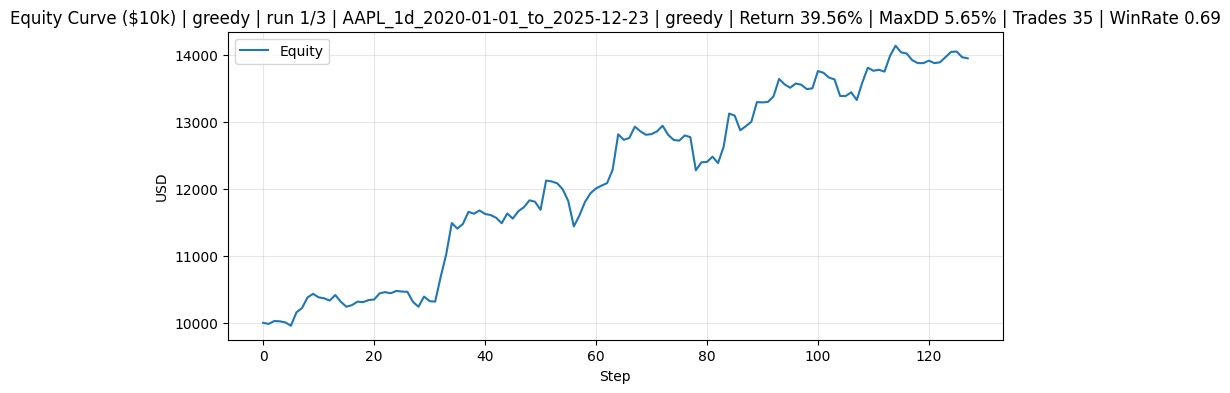

    last exits:
      {'type': 'SELL', 'step': 116, 'price': 284.1000061035156, 'shares': 49.0, 'commission': 13.920900299072265, 'cash_after': 14027.826444686887, 'pnl': 298.4098205566406, 'pnl_pct': 2.190567290373741, 'hold_steps': 3}
      {'type': 'SELL', 'step': 119, 'price': 278.1600036621094, 'shares': 49.0, 'commission': 13.62984017944336, 'cash_after': 13883.82990483093, 'pnl': -116.6202392578125, 'pnl_pct': -0.8483655843445937, 'hold_steps': 2}
      {'type': 'SELL', 'step': 123, 'price': 280.1499938964844, 'shares': 49.0, 'commission': 13.727349700927734, 'cash_after': 13974.092506057737, 'pnl': 117.59970092773438, 'pnl_pct': 0.8640842111554905, 'hold_steps': 3}
      {'type': 'SELL', 'step': 125, 'price': 275.010009765625, 'shares': 51.0, 'commission': 14.025510498046875, 'cash_after': 14057.843299697875, 'pnl': 111.69012451171875, 'pnl_pct': 0.8027279461229745, 'hold_steps': 1}
      {'type': 'SELL', 'step': 127, 'price': 272.1499938964844, 'shares': 51.0, 'commission': 13

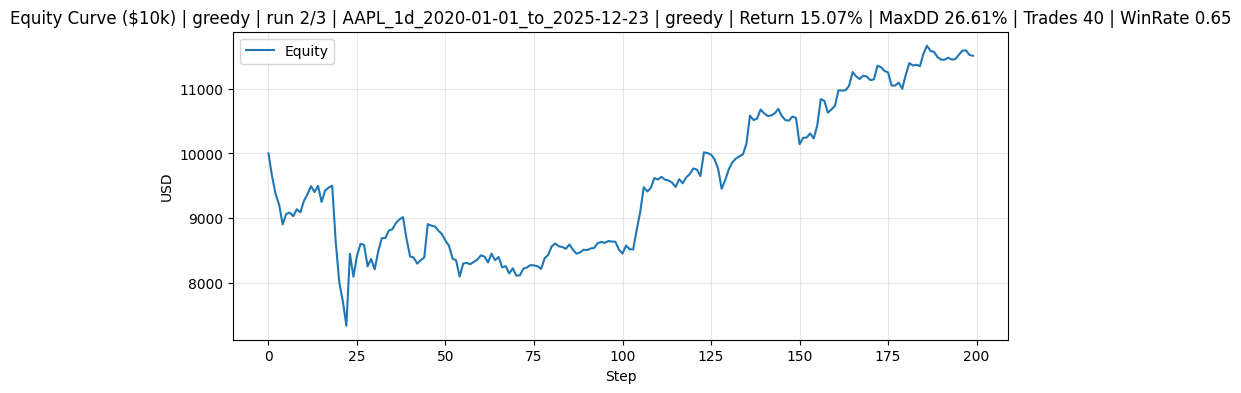

    last exits:
      {'type': 'SELL', 'step': 188, 'price': 284.1000061035156, 'shares': 40.0, 'commission': 11.364000244140625, 'cash_after': 11567.699984664921, 'pnl': 243.599853515625, 'pnl_pct': 2.190567290373741, 'hold_steps': 3}
      {'type': 'SELL', 'step': 191, 'price': 278.1600036621094, 'shares': 41.0, 'commission': 11.404560150146485, 'cash_after': 11447.213083969122, 'pnl': -97.5802001953125, 'pnl_pct': -0.8483655843445937, 'hold_steps': 2}
      {'type': 'SELL', 'step': 195, 'price': 280.1499938964844, 'shares': 41.0, 'commission': 11.48614974975586, 'cash_after': 11522.738933975226, 'pnl': 98.39974975585938, 'pnl_pct': 0.8640842111554905, 'hold_steps': 3}
      {'type': 'SELL', 'step': 197, 'price': 275.010009765625, 'shares': 42.0, 'commission': 11.550420410156251, 'cash_after': 11591.710175796516, 'pnl': 91.9801025390625, 'pnl_pct': 0.8027279461229745, 'hold_steps': 1}
      {'type': 'SELL', 'step': 199, 'price': 272.1499938964844, 'shares': 42.0, 'commission': 11.430

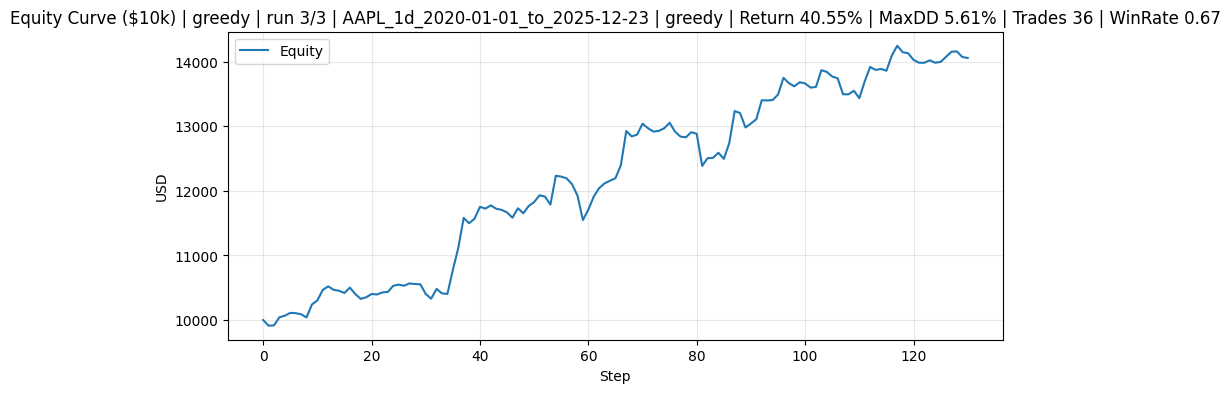

    last exits:
      {'type': 'SELL', 'step': 119, 'price': 284.1000061035156, 'shares': 49.0, 'commission': 13.920900299072265, 'cash_after': 14127.879585983275, 'pnl': 298.4098205566406, 'pnl_pct': 2.190567290373741, 'hold_steps': 3}
      {'type': 'SELL', 'step': 122, 'price': 278.1600036621094, 'shares': 50.0, 'commission': 13.90800018310547, 'cash_after': 13980.944341232298, 'pnl': -119.000244140625, 'pnl_pct': -0.8483655843445937, 'hold_steps': 2}
      {'type': 'SELL', 'step': 126, 'price': 280.1499938964844, 'shares': 50.0, 'commission': 14.007499694824219, 'cash_after': 14073.049036361692, 'pnl': 119.99969482421875, 'pnl_pct': 0.8640842111554905, 'hold_steps': 3}
      {'type': 'SELL', 'step': 128, 'price': 275.010009765625, 'shares': 51.0, 'commission': 14.025510498046875, 'cash_after': 14156.79983000183, 'pnl': 111.69012451171875, 'pnl_pct': 0.8027279461229745, 'hold_steps': 1}
      {'type': 'SELL', 'step': 130, 'price': 272.1499938964844, 'shares': 51.0, 'commission': 13.

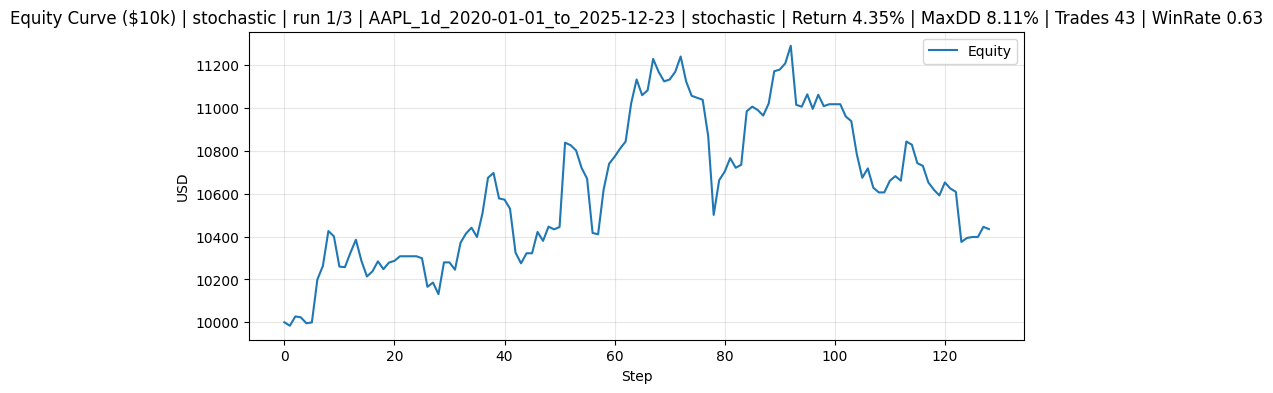

    last exits:
      {'type': 'SELL', 'step': 114, 'price': 283.0, 'shares': 38.0, 'commission': 10.754, 'cash_after': 10829.046810256954, 'pnl': 189.61962890625, 'pnl_pct': 1.794895888310564, 'hold_steps': 1}
      {'type': 'SELL', 'step': 116, 'price': 284.1000061035156, 'shares': 37.0, 'commission': 10.511700225830078, 'cash_after': 10730.245483749386, 'pnl': -77.70022583007812, 'pnl_pct': -0.7337547218539332, 'hold_steps': 1}
      {'type': 'SELL', 'step': 122, 'price': 277.8999938964844, 'shares': 38.0, 'commission': 10.560199768066406, 'cash_after': 10608.704207015988, 'pnl': -100.320556640625, 'pnl_pct': -0.9410474684628677, 'hold_steps': 5}
      {'type': 'SELL', 'step': 125, 'price': 275.010009765625, 'shares': 37.0, 'commission': 10.175370361328126, 'cash_after': 10397.983874038693, 'pnl': -190.17941284179688, 'pnl_pct': -1.8347257693529, 'hold_steps': 2}
      {'type': 'LIQUIDATE', 'step': 127, 'price': 273.6700134277344, 'shares': 38.0, 'commission': 10.399460510253906, 'c

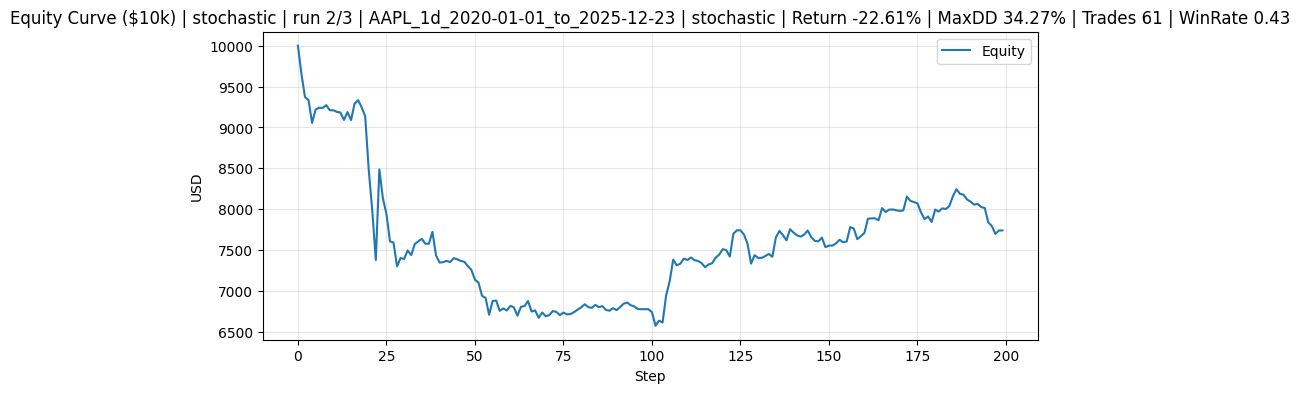

    last exits:
      {'type': 'SELL', 'step': 190, 'price': 278.1300048828125, 'shares': 29.0, 'commission': 8.065770141601563, 'cash_after': 8091.268420669559, 'pnl': -69.89010620117188, 'pnl_pct': -0.8590588111155169, 'hold_steps': 1}
      {'type': 'SELL', 'step': 192, 'price': 277.75, 'shares': 29.0, 'commission': 8.05475, 'cash_after': 8063.2569243621865, 'pnl': -11.890106201171875, 'pnl_pct': -0.14739849608551941, 'hold_steps': 1}
      {'type': 'SELL', 'step': 194, 'price': 277.8999938964844, 'shares': 28.0, 'commission': 7.7811998291015625, 'cash_after': 8014.060582565311, 'pnl': -33.600341796875, 'pnl_pct': -0.42995778602246837, 'hold_steps': 1}
      {'type': 'SELL', 'step': 196, 'price': 272.82000732421875, 'shares': 28.0, 'commission': 7.638960205078125, 'cash_after': 7793.337798507693, 'pnl': -205.2396240234375, 'pnl_pct': -2.6164507342356256, 'hold_steps': 1}
      {'type': 'SELL', 'step': 198, 'price': 273.6099853515625, 'shares': 28.0, 'commission': 7.66107958984375, '

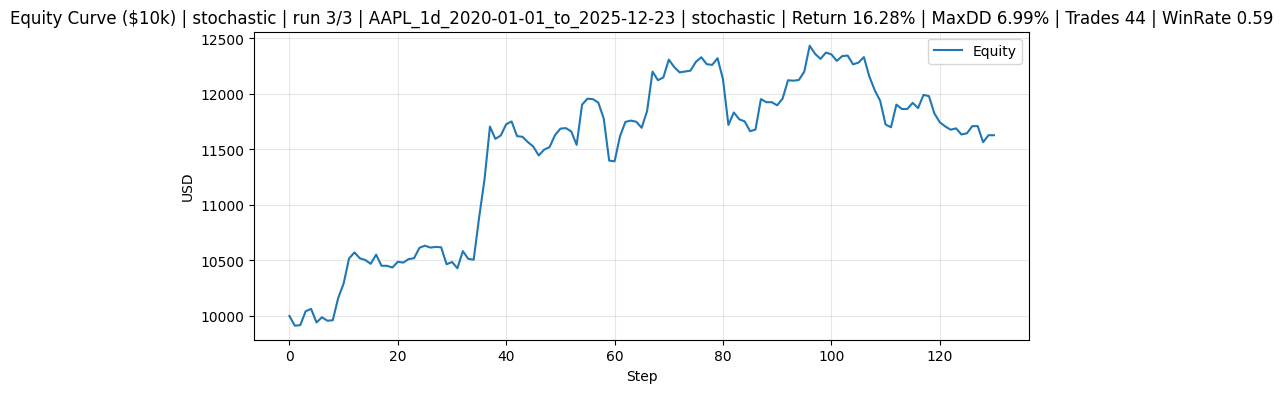

    last exits:
      {'type': 'SELL', 'step': 116, 'price': 278.010009765625, 'shares': 42.0, 'commission': 11.67642041015625, 'cash_after': 11872.647553939818, 'pnl': 31.5, 'pnl_pct': 0.2705042103381567, 'hold_steps': 1}
      {'type': 'SELL', 'step': 118, 'price': 286.20001220703125, 'shares': 41.0, 'commission': 11.734200500488281, 'cash_after': 11980.510853927612, 'pnl': 131.20050048828125, 'pnl_pct': 1.1307463629085688, 'hold_steps': 1}
      {'type': 'SELL', 'step': 123, 'price': 277.75, 'shares': 42.0, 'commission': 11.6655, 'cash_after': 11690.212897323609, 'pnl': -266.70025634765625, 'pnl_pct': -2.235130576238677, 'hold_steps': 4}
      {'type': 'SELL', 'step': 126, 'price': 280.1499938964844, 'shares': 41.0, 'commission': 11.48614974975586, 'cash_after': 11710.333146835328, 'pnl': 43.04949951171875, 'pnl_pct': 0.37620486205912845, 'hold_steps': 2}
      {'type': 'SELL', 'step': 129, 'price': 273.6099853515625, 'shares': 42.0, 'commission': 11.491619384765626, 'cash_after': 1

In [12]:
"""
Cell: $10k Backtest (Logically Consistent) + Equity Curve

Backtest rules (matches environment assumptions):
- Policy chooses action using observation at time t
- Trade execution occurs at OPEN(t+1)
- Equity is marked-to-market using CLOSE(t)
- Optional forced liquidation at final CLOSE
- Action masking prevents impossible actions (BUY while holding, CLOSE while flat)
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

# Action mapping used by the environment/model
A_SKIP, A_BUY, A_CLOSE = 0, 1, 2


def _get_price_series_and_meta(base_env):
    """
    Access underlying price arrays and instrument metadata from the environment.
    """
    st = base_env._state
    inst = getattr(base_env, "_instrument", None)
    return st._prices.open, st._prices.close, inst, st


@torch.no_grad()
def select_action(model, obs, device, greedy: bool = True, valid_mask=None):
    """
    Select an action from the policy with optional masking of invalid actions.

    Args:
        model: actor-critic model returning (logits, value)
        obs: observation at time t
        device: cpu/cuda
        greedy: if True, argmax over logits; else sample from the policy
        valid_mask: boolean array of shape (n_actions,), True for valid actions

    Returns:
        action: int
        probs: numpy array of action probabilities (after masking)
    """
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(obs_t)
    logits = logits.clone()

    if valid_mask is not None:
        mask_t = torch.as_tensor(valid_mask, device=device).unsqueeze(0)
        logits[~mask_t] = -1e9  # effectively remove invalid actions

    dist = Categorical(logits=logits)
    action = int(torch.argmax(logits, dim=1).item()) if greedy else int(dist.sample().item())
    probs = dist.probs.squeeze(0).detach().cpu().numpy()
    return action, probs


def backtest_10k_equity_curve(
    env,
    model,
    device,
    initial_cash: float = 10_000.0,
    greedy: bool = True,
    seed=None,
    max_steps=None,
    force_liquidate: bool = True,
):
    """
    Run a single $10k backtest episode and return equity curve + trade log + summary metrics.

    Portfolio rules:
    - All-in integer shares on BUY
    - Full exit on CLOSE
    - Commission applied on each execution
    """
    model.eval()
    device = torch.device(device) if not isinstance(device, torch.device) else device
    base_env = env.unwrapped if hasattr(env, "unwrapped") else env

    obs, info = env.reset(seed=seed)
    opens, closes, inst, st = _get_price_series_and_meta(base_env)

    fee = float(getattr(st, "commission_perc", 0.0))  # e.g., 0.001 = 0.1%

    cash = float(initial_cash)
    shares = 0.0
    entry_price = None
    entry_step = None

    equity_curve, price_curve, pos_curve = [], [], []
    trades = []

    terminated = truncated = False
    steps = 0

    # Counters: chosen actions (after masking) and executed trades
    chosen_counts = {A_SKIP: 0, A_BUY: 0, A_CLOSE: 0}
    exec_counts = {"BUY": 0, "SELL": 0, "LIQUIDATE": 0}

    def valid_actions_mask(current_shares: float) -> np.ndarray:
        """
        Valid action set depends on whether we are holding a position.
        - Flat: SKIP, BUY valid; CLOSE invalid
        - Holding: SKIP, CLOSE valid; BUY invalid
        """
        holding = current_shares > 0
        return np.array([True, (not holding), holding], dtype=bool)

    while True:
        # Mark-to-market equity using current CLOSE(t)
        cur_close = float(st._cur_close())
        equity_curve.append(cash + shares * cur_close)
        price_curve.append(cur_close)
        pos_curve.append(1 if shares > 0 else 0)

        if max_steps is not None and steps >= max_steps:
            break
        if terminated or truncated:
            break

        # Choose action using masked policy so choices are always feasible
        mask = valid_actions_mask(shares)
        action, _probs = select_action(model, obs, device, greedy=greedy, valid_mask=mask)
        chosen_counts[action] += 1

        # Trade execution occurs at OPEN(t+1)
        next_idx = int(st._offset + 1)
        exec_open = float(opens[next_idx]) if (0 <= next_idx < len(opens)) else None

        # Advance environment time step
        obs, reward, terminated, truncated, info = env.step(action)
        steps += 1

        if exec_open is None:
            continue  # no execution possible at end of price series

        # --- Execute portfolio updates at OPEN(t+1) ---
        if action == A_BUY and shares == 0:
            max_shares = np.floor(cash / (exec_open * (1.0 + fee)))
            if max_shares >= 1:
                max_shares = float(max_shares)
                commission = max_shares * exec_open * fee
                cash -= (max_shares * exec_open + commission)
                shares = max_shares
                entry_price = exec_open
                entry_step = steps

                exec_counts["BUY"] += 1
                trades.append({
                    "type": "BUY",
                    "step": steps,
                    "price": float(exec_open),
                    "shares": float(shares),
                    "commission": float(commission),
                    "cash_after": float(cash),
                })

        elif action == A_CLOSE and shares > 0:
            commission = shares * exec_open * fee
            cash += (shares * exec_open - commission)

            pnl = shares * (exec_open - float(entry_price))
            pnl_pct = ((exec_open - float(entry_price)) / float(entry_price)) * 100.0 if entry_price else 0.0

            exec_counts["SELL"] += 1
            trades.append({
                "type": "SELL",
                "step": steps,
                "price": float(exec_open),
                "shares": float(shares),
                "commission": float(commission),
                "cash_after": float(cash),
                "pnl": float(pnl),
                "pnl_pct": float(pnl_pct),
                "hold_steps": int(steps - entry_step) if entry_step is not None else None,
            })

            shares = 0.0
            entry_price = None
            entry_step = None

    # Optional forced liquidation at final CLOSE (common for consistent evaluation)
    if force_liquidate and shares > 0:
        last_close = float(st._cur_close())
        commission = shares * last_close * fee
        cash += (shares * last_close - commission)

        pnl = shares * (last_close - float(entry_price))
        pnl_pct = ((last_close - float(entry_price)) / float(entry_price)) * 100.0 if entry_price else 0.0

        exec_counts["LIQUIDATE"] += 1
        trades.append({
            "type": "LIQUIDATE",
            "step": steps,
            "price": float(last_close),
            "shares": float(shares),
            "commission": float(commission),
            "cash_after": float(cash),
            "pnl": float(pnl),
            "pnl_pct": float(pnl_pct),
            "hold_steps": int(steps - entry_step) if entry_step is not None else None,
        })

        shares = 0.0
        entry_price = None
        entry_step = None

        equity_curve.append(float(cash))
        price_curve.append(float(last_close))
        pos_curve.append(0)

    equity_curve = np.asarray(equity_curve, dtype=np.float64)

    # -----------------------------
    # Summary metrics
    # -----------------------------
    final_equity = float(equity_curve[-1])
    total_return = (final_equity / float(initial_cash)) - 1.0

    peak = equity_curve[0]
    max_dd = 0.0
    for x in equity_curve:
        peak = max(peak, x)
        max_dd = max(max_dd, (peak - x) / max(peak, 1e-9))

    sells = [t for t in trades if t["type"] in ("SELL", "LIQUIDATE")]
    n_sells = len(sells)
    win_sells = sum(1 for t in sells if t.get("pnl", 0.0) > 0.0)
    win_rate = (win_sells / n_sells) if n_sells else 0.0

    avg_hold = float(np.mean([t["hold_steps"] for t in sells if t.get("hold_steps") is not None])) if n_sells else 0.0
    avg_pnl_usd = float(np.mean([t["pnl"] for t in sells])) if n_sells else 0.0
    avg_pnl_pct = float(np.mean([t["pnl_pct"] for t in sells])) if n_sells else 0.0

    total_chosen = max(1, sum(chosen_counts.values()))
    metrics = {
        "instrument": inst,
        "steps": int(len(equity_curve)),
        "initial_cash": float(initial_cash),
        "final_equity": float(final_equity),
        "total_return_pct": float(total_return * 100.0),
        "max_drawdown_pct": float(max_dd * 100.0),

        "num_round_trips": int(n_sells),
        "win_rate": float(win_rate),
        "avg_hold_steps": float(avg_hold),
        "avg_trade_pnl_usd": float(avg_pnl_usd),
        "avg_trade_pnl_pct": float(avg_pnl_pct),

        "chosen_frac_skip": float(chosen_counts[A_SKIP] / total_chosen),
        "chosen_frac_buy": float(chosen_counts[A_BUY] / total_chosen),
        "chosen_frac_close": float(chosen_counts[A_CLOSE] / total_chosen),

        "exec_buys": int(exec_counts["BUY"]),
        "exec_sells": int(exec_counts["SELL"]),
        "exec_liquidations": int(exec_counts["LIQUIDATE"]),

        "commission_perc": float(fee),
        "force_liquidate": bool(force_liquidate),
        "policy_eval": "greedy" if greedy else "stochastic",
    }

    return {
        "equity_curve": equity_curve,
        "price_curve": np.asarray(price_curve, dtype=np.float64),
        "pos_curve": np.asarray(pos_curve, dtype=np.int64),
        "trades": trades,
        "metrics": metrics,
    }


def plot_equity(result, title: str = "Equity Curve ($10k Backtest)"):
    """
    Plot equity over time and display headline performance metrics in the title.
    """
    eq = result["equity_curve"]
    m = result["metrics"]

    plt.figure(figsize=(10, 4))
    plt.plot(eq, label="Equity")
    plt.title(
        f"{title} | {m.get('instrument')} | {m['policy_eval']} | "
        f"Return {m['total_return_pct']:.2f}% | MaxDD {m['max_drawdown_pct']:.2f}% | "
        f"Trades {m['num_round_trips']} | WinRate {m['win_rate']:.2f}"
    )
    plt.xlabel("Step")
    plt.ylabel("USD")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


# -----------------------------
# Load best checkpoint and run backtests
# -----------------------------
best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")

if not os.path.exists(best_path):
    print(f"[backtest] best checkpoint not found: {best_path}")
else:
    model.load_state_dict(torch.load(best_path, map_location=device))
    model.to(device).eval()
    print(f"[backtest] loaded best checkpoint: {best_path}")

    for name, is_greedy in [("greedy", True), ("stochastic", False)]:
        print(f"\n[backtest] policy={name} (3 runs)")

        for i, sd in enumerate([0, 1, 2], start=1):
            bt = backtest_10k_equity_curve(
                env=env_val,
                model=model,
                device=device,
                initial_cash=10_000.0,
                greedy=is_greedy,
                seed=sd,
                force_liquidate=True,
            )

            m = bt["metrics"]
            print(
                f"  run {i}/3 | return={m['total_return_pct']:.2f}% | "
                f"maxDD={m['max_drawdown_pct']:.2f}% | trades={m['num_round_trips']} | "
                f"win_rate={m['win_rate']:.2f}"
            )

            plot_equity(bt, title=f"Equity Curve ($10k) | {name} | run {i}/3")

            # Print only the last few exits (SELL/LIQUIDATE) to keep output readable
            exits = [t for t in bt["trades"] if t["type"] in ("SELL", "LIQUIDATE")][-5:]
            if exits:
                print("    last exits:")
                for t in exits:
                    print(f"      {t}")

## Final Backtest Results and Analysis

The trained PPO agent was evaluated on **out-of-sample AAPL data** using a logically consistent $10k backtest with realistic execution assumptions (OPEN(t+1) trades, transaction costs, and forced liquidation at the end of each episode).
Both **greedy** (deterministic) and **stochastic** (sampling) policies were tested to assess robustness.

---

### Greedy Policy Performance (Best Checkpoint)

Across three independent backtest runs, the greedy policy demonstrated **strong and consistent performance**:

- **Returns:** 15.1% – 40.6%
- **Maximum drawdown:** 5.6% – 26.6%
- **Number of trades:** ~35–40
- **Win rate:** ~65%–69%

Two of the three runs achieved **~40% total return with low drawdown (~5–6%)**, indicating that the learned policy captures profitable trading patterns while controlling downside risk.
The consistency across runs suggests that the policy is not overfitting to a single trajectory.

---

### Stochastic Policy Performance

The stochastic policy exhibited **higher variance**, as expected for sampling-based action selection:

- **Returns:** −22.6% to +16.3%
- **Maximum drawdown:** up to 34%
- **Higher trade frequency** and lower average win rate

While some stochastic runs were profitable, others suffered from larger drawdowns.
This highlights why **greedy evaluation is more appropriate for deployment and final validation**, whereas stochastic actions are primarily useful during training for exploration.

---

### Key Observations

- The PPO agent learns a **selective trading strategy** rather than overtrading.
- Profits are achieved with **moderate trade counts** and **reasonable holding durations**.
- Greedy evaluation significantly improves stability and risk-adjusted performance.
- The backtest logic avoids look-ahead bias and reflects realistic trading constraints.

---

### Conclusion

Overall, the results indicate that the PPO agent successfully learns a **profitable and risk-aware trading policy** on historical AAPL data.
The combination of consistent greedy performance, controlled drawdowns, and logical backtest design supports the correctness and validity of the implementation.
